In [38]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import preliz as pz

import pymc as pm

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
seed: int = sum(map(ord, "seed"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

In [40]:
def generate_synthetic_data(rng, start, stop, num, scale):
    x = np.linspace(start=start, stop=stop, num=num)
    y = np.cos(4 * np.pi * x) + np.cos(7 * np.pi * x)
    y_obs = y + scale * rng.normal(size=num)
    return x, y, y_obs


n_train = 80
n_test = 100
scale = 0.3


x_train, y_train, y_train_obs = generate_synthetic_data(
    rng=rng, start=0, stop=1, num=n_train, scale=scale
)

x_test, y_test, y_test_obs = generate_synthetic_data(
    rng=rng, start=0, stop=1, num=n_test, scale=scale
)

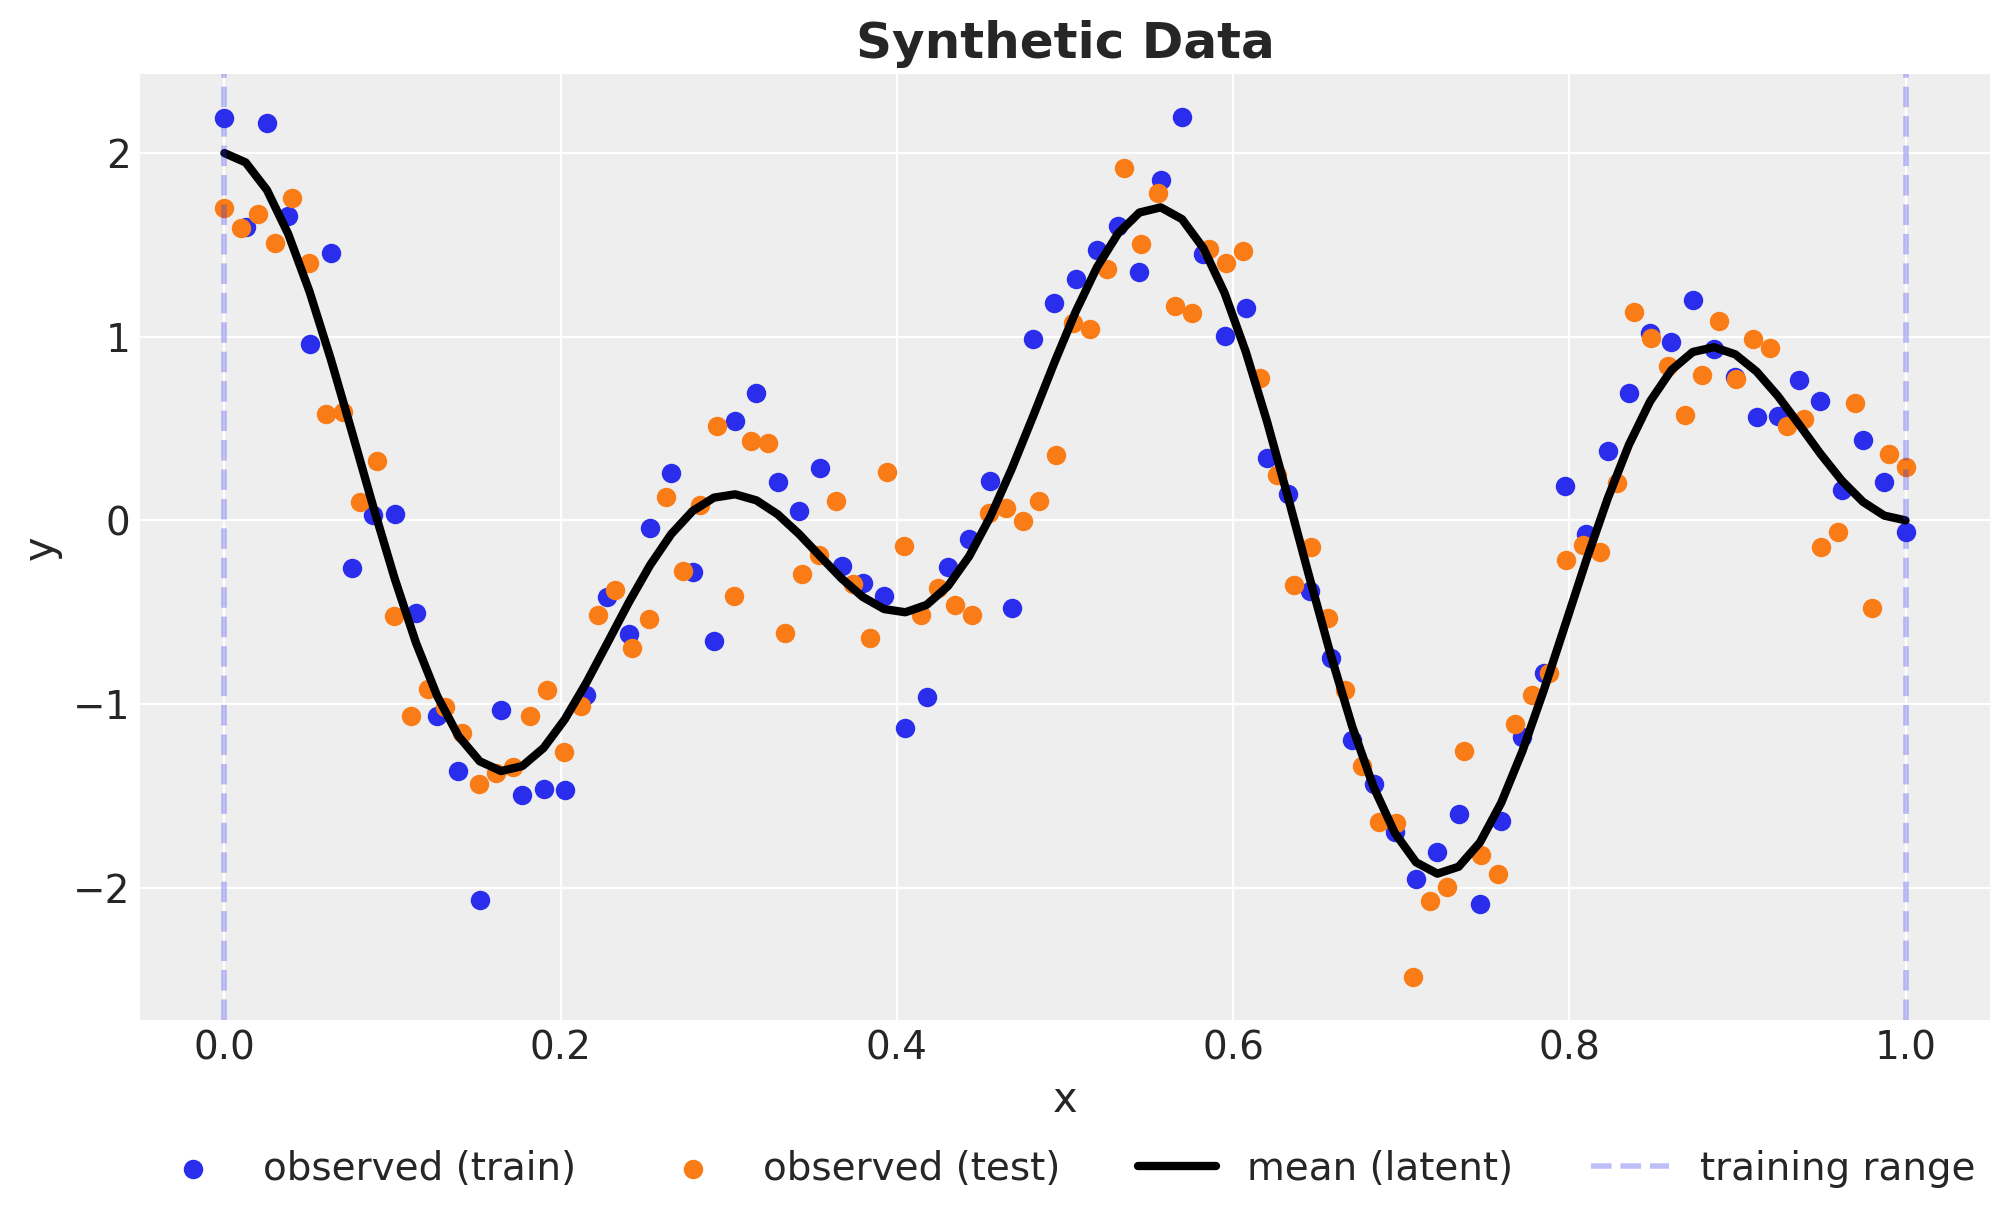

In [41]:
fig, ax = plt.subplots()
ax.scatter(x_train, y_train_obs, c="C0", label="observed (train)")
ax.scatter(x_test, y_test_obs, c="C1", label="observed (test)")
ax.plot(x_train, y_train, color="black", linewidth=3, label="mean (latent)")
ax.axvline(x=0, color="C0", alpha=0.3, linestyle="--", linewidth=2)
ax.axvline(x=1, color="C0", linestyle="--", alpha=0.3, linewidth=2, label="training range")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=4)
ax.set(xlabel="x", ylabel="y")
ax.set_title("Synthetic Data", fontsize=18, fontweight="bold");

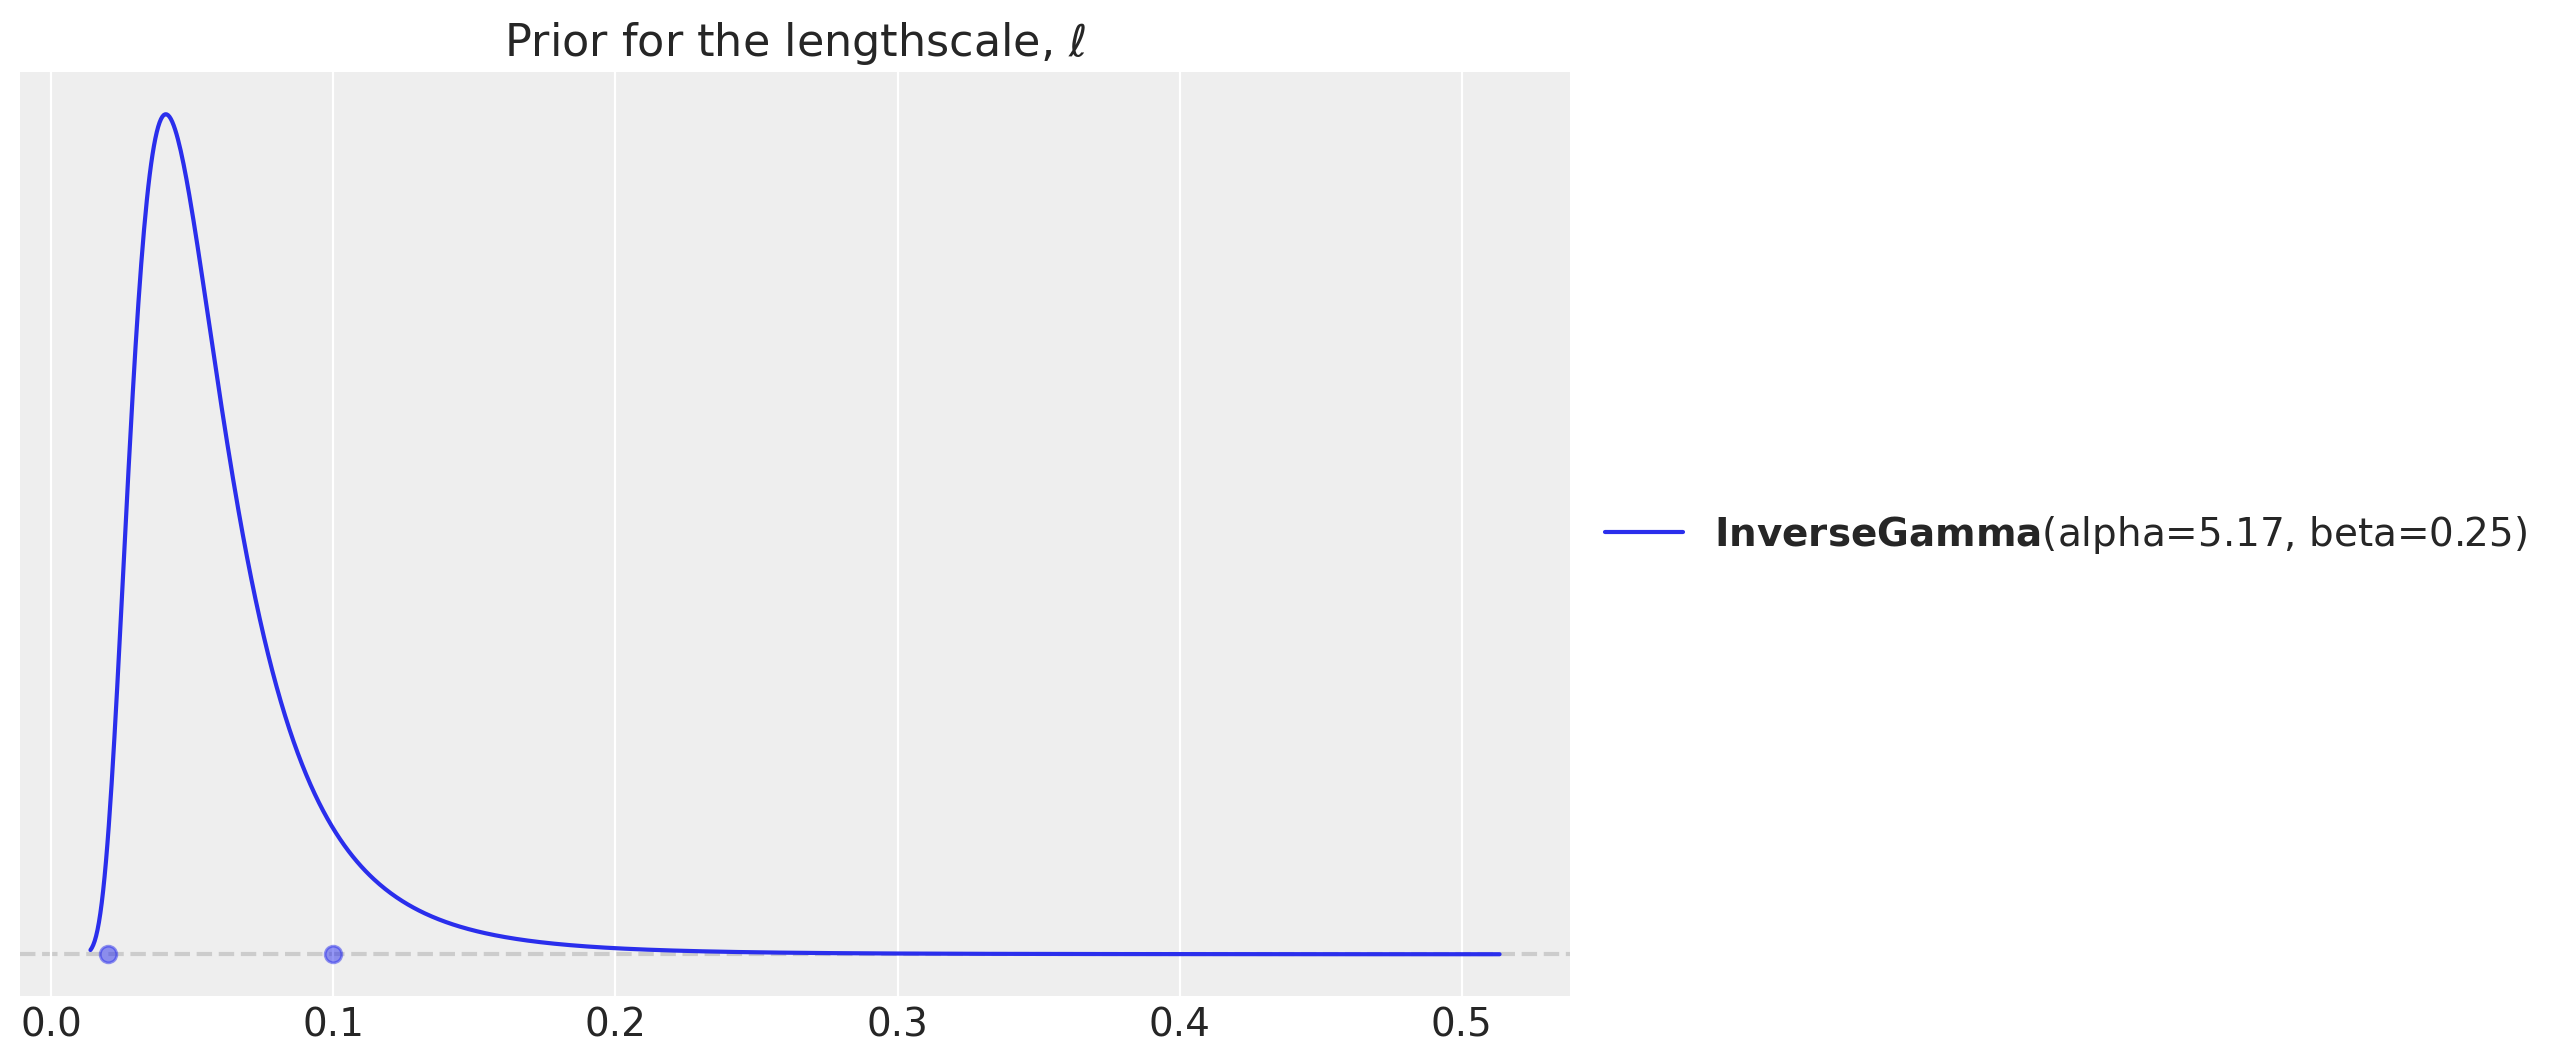

In [42]:
lower, upper = 0.02, 0.1
ell_dist, ax = pz.maxent(
    pz.InverseGamma(),
    lower=lower,
    upper=upper,
    mass=0.9,
)

ax.set_title(r"Prior for the lengthscale, $\ell$");

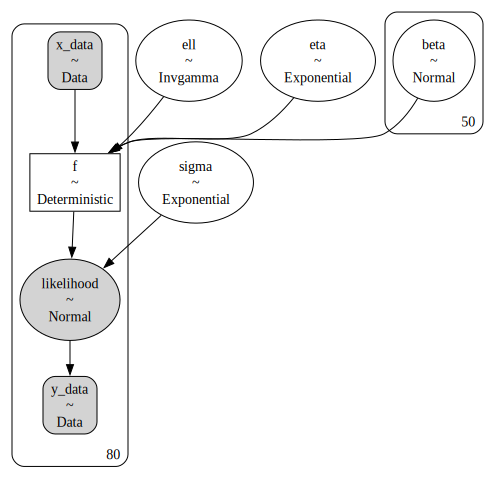

In [43]:
m = 50
c = 1.2


def build_model(m, c, ell_dist, boundary):
    with pm.Model() as model:
        x_train_mean = np.array(x_train).mean(axis=0)
        x_data = pm.Data("x_data", value=x_train)
        x_data_centered = x_data - x_train_mean
        y_data = pm.Data("y_data", value=y_train_obs)

        ell = ell_dist.to_pymc("ell")
        eta = pm.Exponential("eta", scale=1.0)
        cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=1, ls=ell)

        sigma = pm.Exponential("sigma", scale=1.0)

        parametrization = "centered"
        mean = pm.gp.mean.Zero()
        cov = eta**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ell)
        gp = pm.gp.HSGP(
            m=[m],
            c=c,
            mean_func=mean,
            cov_func=cov,
            parametrization=parametrization,
            boundary=boundary,
        )

        phi, sqrt_psd = gp.prior_linearized(X=x_data_centered[:, None])

        beta = pm.Normal("beta", mu=0, sigma=1, size=gp._m_star)
        f = pm.Deterministic("f", phi @ (beta * sqrt_psd))

        pm.Normal("likelihood", mu=f, sigma=sigma, observed=y_data)

    return model


dirichlet_model = build_model(m, c, ell_dist, "dirichlet")
neumann_model = build_model(m, c, ell_dist, "neumann")

pm.model_to_graphviz(dirichlet_model)

In [44]:
%%time

with dirichlet_model:
    dirichlet_idata = pm.sample(
        num_chains=4, num_samples=1_000, nuts_sampler="nutpie", random_seed=seed
    )

    pm.set_data(
        {"x_data": x_test, "y_data": np.ones_like(x_test)},
    )
    dirichlet_idata.extend(
        pm.sample_posterior_predictive(
            trace=dirichlet_idata,
            var_names=["f", "likelihood"],
            random_seed=seed,
        )
    )

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,15,0.34,15
,2000,0,0.29,15
,2000,0,0.35,15
,2000,5,0.37,15


Sampling: [likelihood]


Output()

CPU times: user 5.56 s, sys: 163 ms, total: 5.73 s
Wall time: 4.37 s


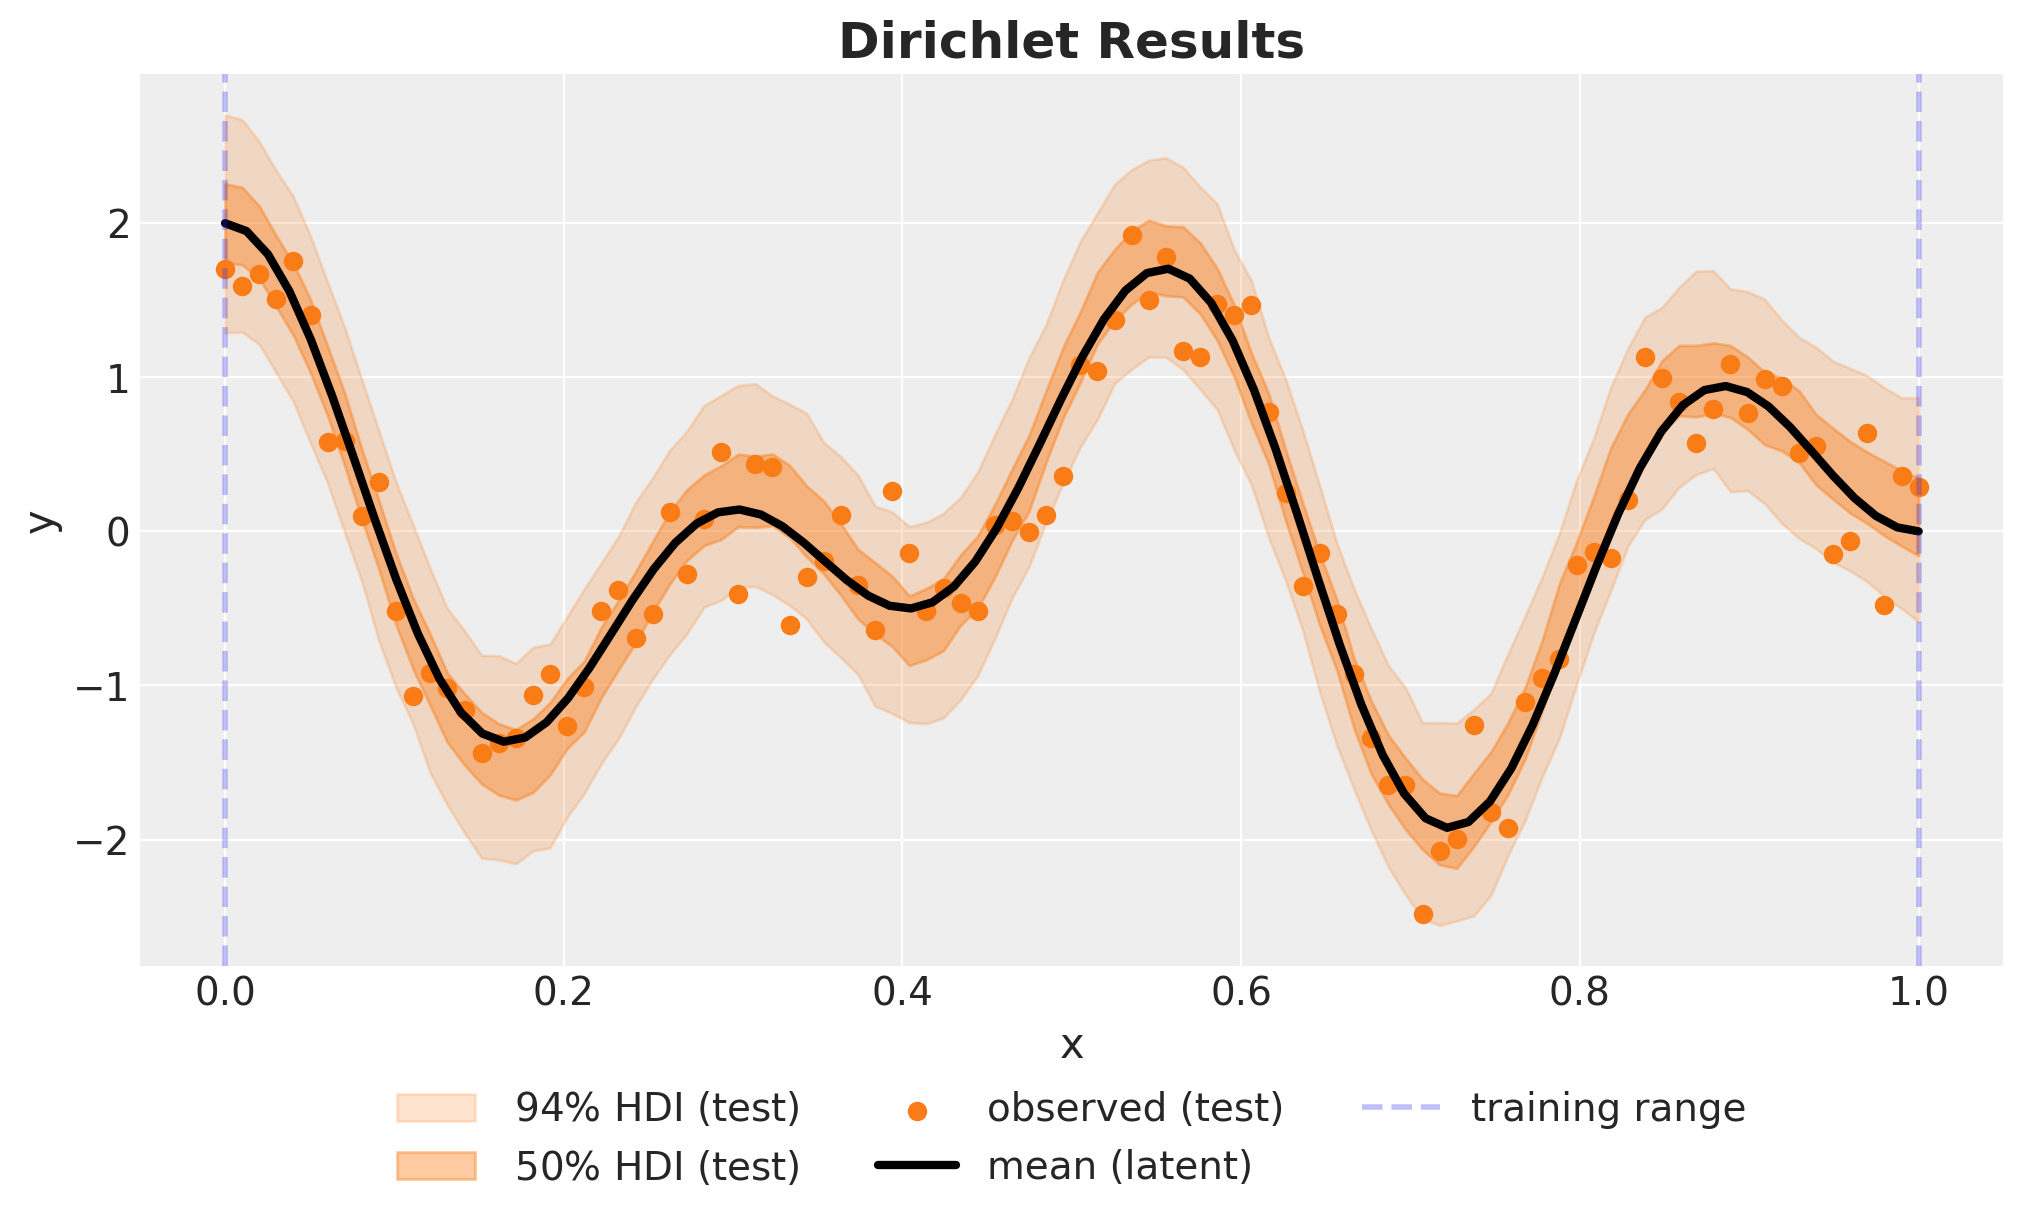

In [45]:
fig, ax = plt.subplots()
az.plot_hdi(
    x_test,
    dirichlet_idata["posterior_predictive"]["likelihood"],
    hdi_prob=0.94,
    color="C1",
    smooth=False,
    fill_kwargs={"alpha": 0.2, "label": "$\\: 94\\%$ HDI (test)"},
    ax=ax,
)
az.plot_hdi(
    x_test,
    dirichlet_idata["posterior_predictive"]["likelihood"],
    hdi_prob=0.5,
    color="C1",
    smooth=False,
    fill_kwargs={"alpha": 0.4, "label": "$\\: 50\\%$ HDI (test)"},
    ax=ax,
)
ax.scatter(x_test, y_test_obs, c="C1", label="observed (test)")
ax.plot(x_train, y_train, color="black", linewidth=3, label="mean (latent)")
ax.axvline(x=0, color="C0", alpha=0.3, linestyle="--", linewidth=2)
ax.axvline(x=1, color="C0", linestyle="--", alpha=0.3, linewidth=2, label="training range")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)
ax.set(xlabel="x", ylabel="y")
ax.set_title("Dirichlet Results", fontsize=18, fontweight="bold");

In [46]:
%%time

with neumann_model:
    neumann_idata = pm.sample(
        num_chains=4, num_samples=1_000, nuts_sampler="nutpie", random_seed=seed
    )

    pm.set_data(
        {"x_data": x_test, "y_data": np.ones_like(x_test)},
    )
    neumann_idata.extend(
        pm.sample_posterior_predictive(
            trace=neumann_idata,
            var_names=["f", "likelihood"],
            random_seed=seed,
        )
    )

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.38,15
,2000,0,0.38,15
,2000,0,0.35,15
,2000,0,0.32,15


Sampling: [likelihood]


Output()

CPU times: user 5.75 s, sys: 143 ms, total: 5.9 s
Wall time: 3.65 s


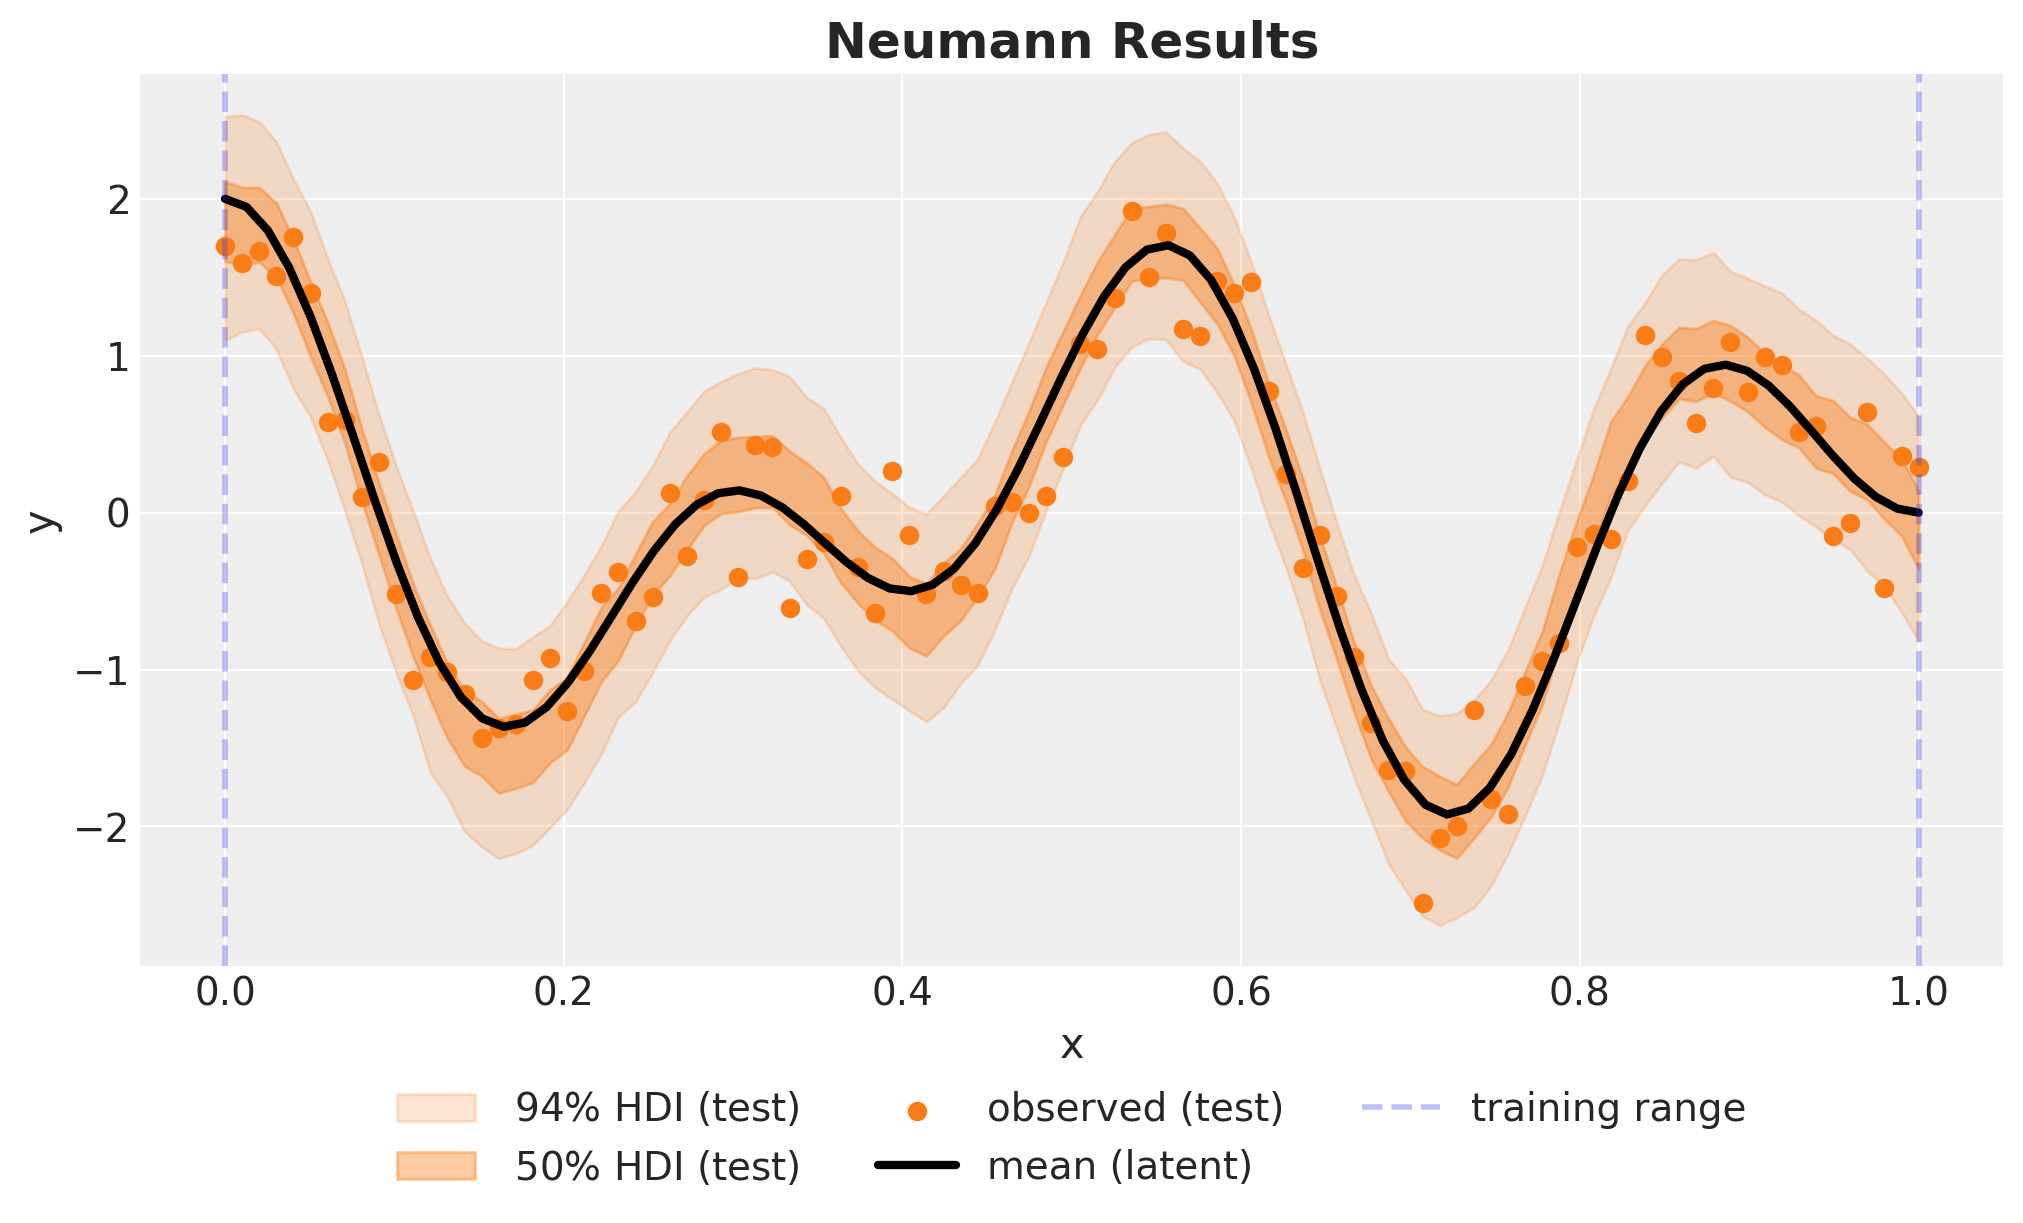

In [47]:
fig, ax = plt.subplots()
az.plot_hdi(
    x_test,
    neumann_idata["posterior_predictive"]["likelihood"],
    hdi_prob=0.94,
    color="C1",
    smooth=False,
    fill_kwargs={"alpha": 0.2, "label": "$\\: 94\\%$ HDI (test)"},
    ax=ax,
)
az.plot_hdi(
    x_test,
    neumann_idata["posterior_predictive"]["likelihood"],
    hdi_prob=0.5,
    color="C1",
    smooth=False,
    fill_kwargs={"alpha": 0.4, "label": "$\\: 50\\%$ HDI (test)"},
    ax=ax,
)
ax.scatter(x_test, y_test_obs, c="C1", label="observed (test)")
ax.plot(x_train, y_train, color="black", linewidth=3, label="mean (latent)")
ax.axvline(x=0, color="C0", alpha=0.3, linestyle="--", linewidth=2)
ax.axvline(x=1, color="C0", linestyle="--", alpha=0.3, linewidth=2, label="training range")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)
ax.set(xlabel="x", ylabel="y")
ax.set_title("Neumann Results", fontsize=18, fontweight="bold");

In [48]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Wed, 31 Dec 2025

Python implementation: CPython
Python version       : 3.13.11
IPython version      : 9.8.0

arviz     : 0.23.0
matplotlib: 3.10.8
numpy     : 2.3.5
preliz    : 0.23.0
pymc      : 0+untagged.10359.ga375fd1

Watermark: 2.6.0

